In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessedbiodiesel/Fully_Preprocessed_Compiled_Dataset.xlsx


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [4]:
# Load preprocessed data and sanitize for compatibility
df = pd.read_excel("/kaggle/input/preprocessedbiodiesel/Fully_Preprocessed_Compiled_Dataset.xlsx")
df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)

In [5]:
df.dtypes

Molar_Ratio_MeOH__Oil_    float64
Catalyst_Dose_wt__        float64
Reaction_temp__C_         float64
Reaction_Time_hr_         float64
Biodiesel_yield___        float64
dtype: object

In [6]:
df.describe()

,Molar_Ratio_MeOH__Oil_,Catalyst_Dose_wt__,Reaction_temp__C_,Reaction_Time_hr_,Biodiesel_yield___
count,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03
mean,-2.821650e-16,-8.977977e-17,5.130272e-17,2.292591e-16,1.154311e-16
std,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00
min,-2.069885e+00,-1.105972e+00,-2.585917e+00,-1.538945e+00,-3.095890e+00
25%,-7.653066e-01,-8.175230e-01,-6.047841e-01,-7.648045e-01,-5.901564e-01
50%,-1.130174e-01,-3.236034e-01,-1.095009e-01,-2.471152e-01,2.762520e-01
75%,5.392719e-01,8.618035e-01,3.857822e-01,3.997053e-01,7.762166e-01
max,3.365859e+00,3.232618e+00,2.862198e+00,3.116895e+00,1.288539e+00


In [7]:
df.head()

,Molar_Ratio_MeOH__Oil_,Catalyst_Dose_wt__,Reaction_temp__C_,Reaction_Time_hr_,Biodiesel_yield___
0,-1.961170,0.861804,0.385782,0.399705,0.174164
1,-0.113017,0.071532,0.881065,0.787875,1.019886
2,-0.113017,-0.126036,0.385782,0.787875,0.117209
3,-0.706601,-0.714788,0.385782,2.340555,1.044602
4,-0.113017,0.071532,0.385782,3.116895,0.568547


In [8]:
# Separate features and target
X = df.drop(columns=df.columns[-1])  # Assuming the last column is the target
y = df[df.columns[-1]]

In [9]:
# First split into train and temp (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Now split temp into validation and test (15% val, 15% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [10]:
# Dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=1.0),
    "SVR": SVR(kernel='rbf'),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}


In [11]:
# Store metrics
rmse_scores = {}
mae_scores = {}
r2_scores = {}

In [12]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # R² Scores
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print results
    print(f"{name}:")
    print(f"  Train      → RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"  Validation → RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
    print(f"  Test       → RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}\n")

    # Store test metrics
    rmse_scores[name] = test_rmse
    mae_scores[name] = test_mae
    r2_scores[name] = test_r2

Linear Regression:
  Train      → RMSE: 0.9997, MAE: 0.8078, R²: 0.0078
  Validation → RMSE: 0.9963, MAE: 0.8162, R²: -0.0014
  Test       → RMSE: 0.9937, MAE: 0.8050, R²: -0.0135

Lasso Regression:
  Train      → RMSE: 1.0036, MAE: 0.8124, R²: 0.0000
  Validation → RMSE: 0.9956, MAE: 0.8187, R²: -0.0000
  Test       → RMSE: 0.9877, MAE: 0.8030, R²: -0.0012

Ridge Regression:
  Train      → RMSE: 0.9997, MAE: 0.8078, R²: 0.0078
  Validation → RMSE: 0.9963, MAE: 0.8162, R²: -0.0014
  Test       → RMSE: 0.9937, MAE: 0.8050, R²: -0.0134

SVR:
  Train      → RMSE: 0.9374, MAE: 0.6574, R²: 0.1275
  Validation → RMSE: 0.9378, MAE: 0.6826, R²: 0.1128
  Test       → RMSE: 0.9640, MAE: 0.6816, R²: 0.0463

KNN Regressor:
  Train      → RMSE: 0.7982, MAE: 0.5896, R²: 0.3674
  Validation → RMSE: 0.9402, MAE: 0.7146, R²: 0.1081
  Test       → RMSE: 0.9362, MAE: 0.7109, R²: 0.1004

Decision Tree:
  Train      → RMSE: 0.3109, MAE: 0.1283, R²: 0.9040
  Validation → RMSE: 1.0981, MAE: 0.7243, R²: -0.21

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-06-12 12:57:31.945092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749733051.968158    5589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749733051.975254    5589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# ANN Model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

I0000 00:00:1749733054.829006    5589 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping
early_stop = EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


I0000 00:00:1749733059.227818    5654 service.cc:148] XLA service 0x7b734c014790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749733059.227852    5654 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749733059.567344    5654 cuda_dnn.cc:529] Loaded cuDNN version 90300


45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6811

I0000 00:00:1749733061.701503    5654 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.6601 - val_loss: 0.9922
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1289 - val_loss: 1.0096
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1027 - val_loss: 0.9878
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0069 - val_loss: 0.9643
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0173 - val_loss: 0.9627
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9633 - val_loss: 0.9341
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8582 - val_loss: 0.8906
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9683 - val_loss: 0.8510
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0880 - val_loss: 0.8568
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9536 - val_loss: 0.8613
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9218 - val_loss: 0.8496
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9538 - val_l

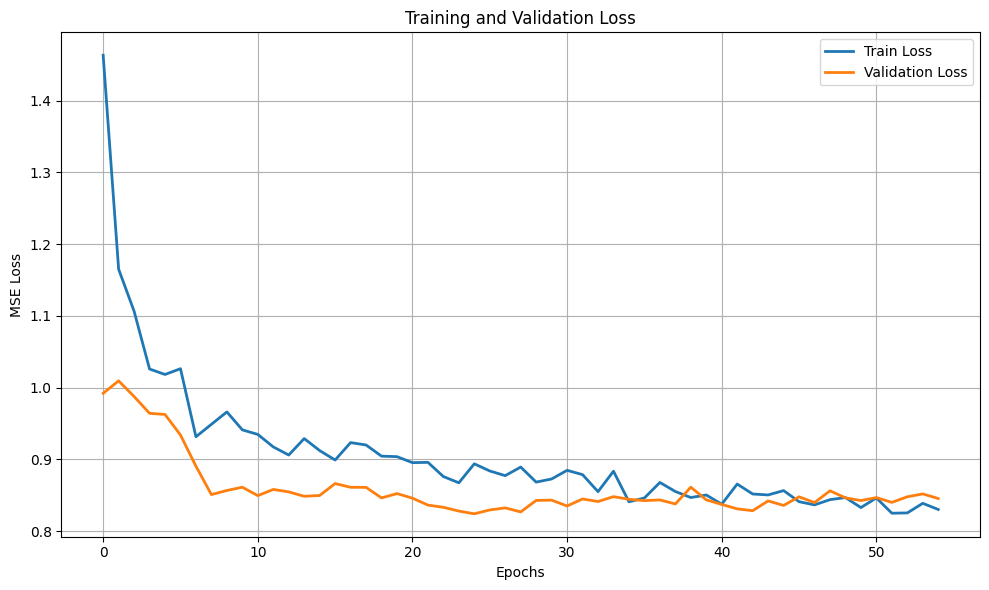

In [16]:
import matplotlib.pyplot as plt
# 📊 Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Predictions
y_train_pred = model.predict(X_train).flatten()
y_val_pred = model.predict(X_val).flatten()
y_test_pred = model.predict(X_test).flatten()


# Metrics function with storage
def store_and_print_metrics(true, pred, label):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Store in dictionaries
    rmse_scores[f"ANN {label}"] = rmse
    mae_scores[f"ANN {label}"] = mae
    r2_scores[f"ANN {label}"] = r2

# Apply for each set
store_and_print_metrics(y_train, y_train_pred, "Train")
store_and_print_metrics(y_val, y_val_pred, "Validation")
store_and_print_metrics(y_test, y_test_pred, "Test")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train → RMSE: 0.8914, MAE: 0.6962, R²: 0.2110
Validation → RMSE: 0.9079, MAE: 0.7080, R²: 0.1684
Test → RMSE: 0.9087, MAE: 0.7150, R²: 0.1525


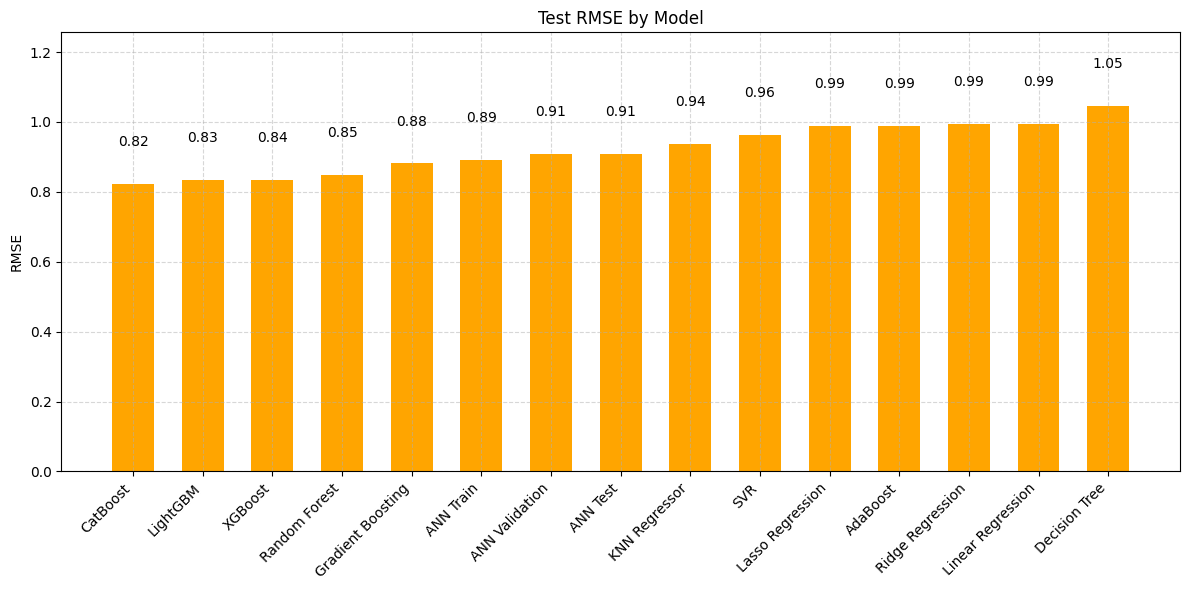

In [18]:
# Sort RMSE
sorted_rmse = dict(sorted(rmse_scores.items(), key=lambda x: x[1]))

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_rmse.keys(), sorted_rmse.values(), color='orange', width=0.6)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Test RMSE by Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)

# Set y-axis limit slightly above the highest bar
max_rmse = max(sorted_rmse.values())
plt.ylim(0, max_rmse * 1.2)

plt.tight_layout()
plt.show()


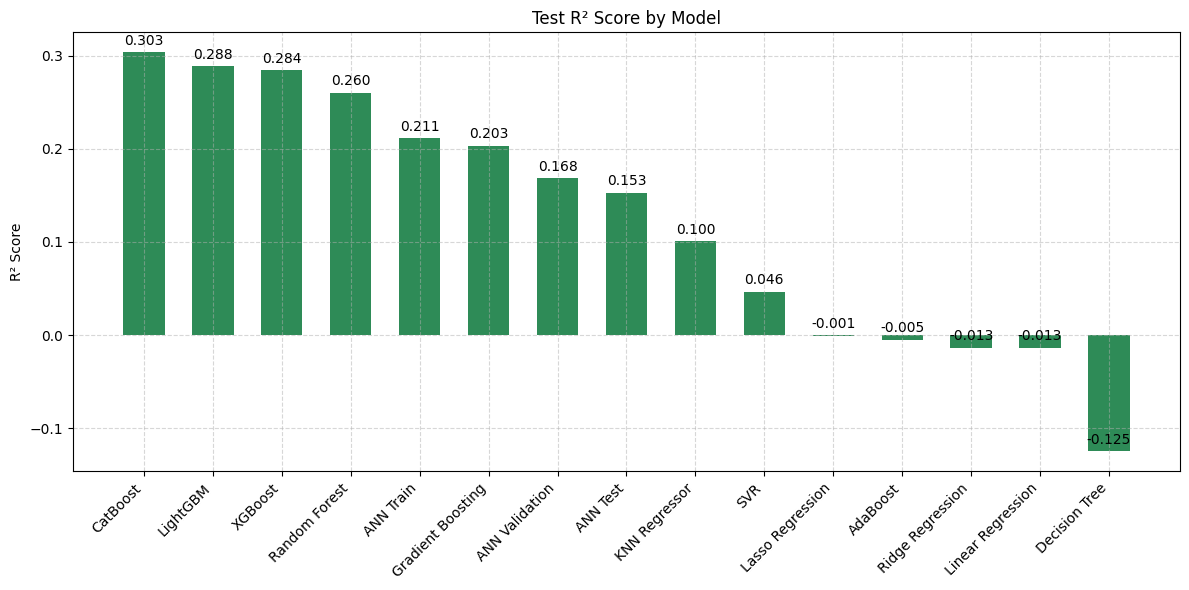

In [19]:
# Sort R² (Plotting r2 scores)
sorted_r2 = dict(sorted(r2_scores.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_r2.keys(), sorted_r2.values(), color='seagreen', width=0.6)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Test R² Score by Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


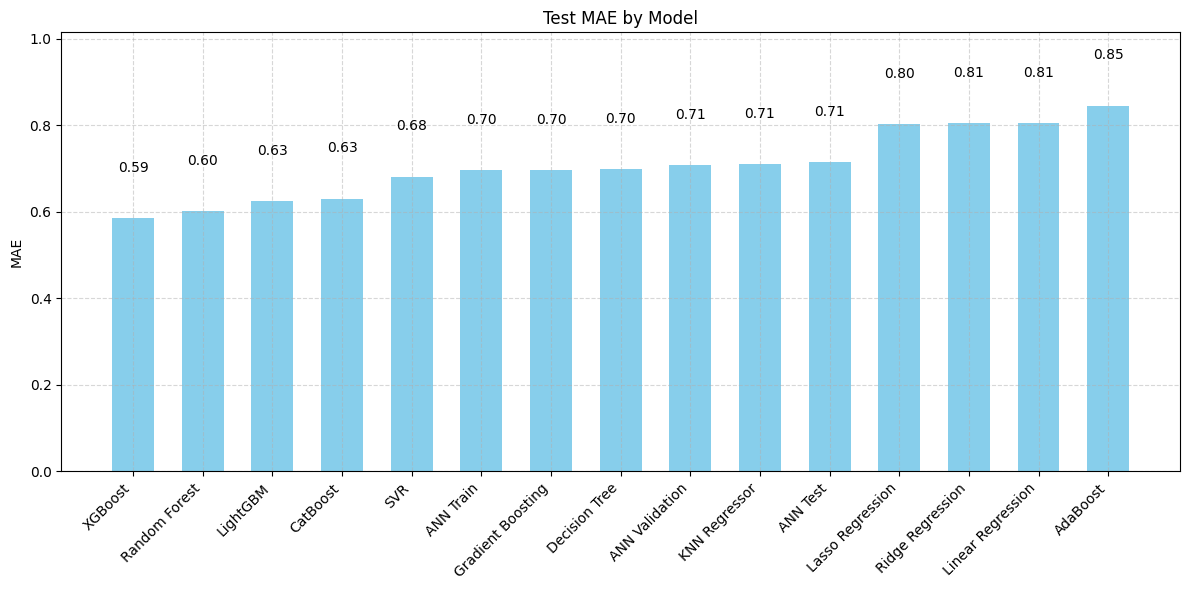

In [20]:
# Sort MAE scores
sorted_mae = dict(sorted(mae_scores.items(), key=lambda x: x[1]))

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_mae.keys(), sorted_mae.values(), color='skyblue', width=0.6)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Test MAE by Model")
plt.ylabel("MAE")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)

# Set y-axis limit slightly above the highest bar
max_mae = max(sorted_mae.values())
plt.ylim(0, max_mae * 1.2)

plt.tight_layout()
plt.show()

**Hyperparameter Tuning**

RandomizeSearch

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
# Define hyperparameter search spaces
param_dist_catboost = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 300, 500, 700],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1.0]
}

param_dist_lightgbm = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

param_dist_xgb = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize models
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
lightgbm_model = LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

# Store results
random_search_results = {}

In [23]:
# Utility function to run RandomizedSearchCV
def run_random_search(existing_model, param_dist, model_name):
    search = RandomizedSearchCV(
        estimator=existing_model,
        param_distributions=param_dist,
        n_iter=30,
        cv=3,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name} ➤ Test RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    print(f"Best Hyperparameters for {model_name}: {search.best_params_}\n")

    random_search_results[model_name] = {
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'best_params': search.best_params_
    }

In [24]:
#Run tuning and show results
run_random_search(lightgbm_model, param_dist_lightgbm, "LightGBM")
run_random_search(xgb_model, param_dist_xgb, "XGBoost")
run_random_search(catboost_model, param_dist_catboost, "CatBoost")

LightGBM ➤ Test RMSE: 0.8412, R²: 0.2737, MAE: 0.6440
Best Hyperparameters for LightGBM: {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

XGBoost ➤ Test RMSE: 0.8194, R²: 0.3109, MAE: 0.6306
Best Hyperparameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

CatBoost ➤ Test RMSE: 0.8324, R²: 0.2888, MAE: 0.6417
Best Hyperparameters for CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6, 'bagging_temperature': 0}



Bayesian Optimization algorithm

In [25]:
!pip install scikit-optimize

In [26]:
from skopt import BayesSearchCV

# Dictionary to store Bayesian optimization results
bayes_opt_results = {}


In [27]:
# Utility function to run Bayesian Optimization
def run_bayesian_optimization(existing_model, param_space, model_name):
    opt = BayesSearchCV(
        estimator=existing_model,
        search_spaces=param_space,
        n_iter=30,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    opt.fit(X_train, y_train)
    best_model = opt.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print Results
    print(f"{model_name} ➤ Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print(f"Best Hyperparameters for {model_name}: {opt.best_params_}\n")

    # Store Results
    bayes_opt_results[model_name] = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'best_params': opt.best_params_
    }

# --------------------------------------------------
# Define search spaces

lgb_param_space = {
    'num_leaves': (20, 60),
    'max_depth': (3, 10),
    'learning_rate': (1e-3, 0.3, 'log-uniform'),
    'n_estimators': (50, 300),
    'min_child_samples': (5, 30)
}

xgb_param_space = {
    'max_depth': (3, 10),
    'learning_rate': (1e-3, 0.3, 'log-uniform'),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

cat_param_space = {
    'depth': (3, 10),
    'learning_rate': (1e-3, 0.3, 'log-uniform'),
    'iterations': (50, 300),
    'l2_leaf_reg': (1, 10)
}

# --------------------------------------------------
# Run Bayesian Optimization

run_bayesian_optimization(lightgbm_model, lgb_param_space, "LightGBM")
run_bayesian_optimization(xgb_model, xgb_param_space, "XGBoost")
run_bayesian_optimization(catboost_model, cat_param_space, "CatBoost")

LightGBM ➤ Test RMSE: 0.8318, MAE: 0.6432, R²: 0.2899
Best Hyperparameters for LightGBM: OrderedDict([('learning_rate', 0.04595533460059185), ('max_depth', 8), ('min_child_samples', 5), ('n_estimators', 161), ('num_leaves', 20)])

XGBoost ➤ Test RMSE: 0.8158, MAE: 0.6283, R²: 0.3170
Best Hyperparameters for XGBoost: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.07624899536981787), ('max_depth', 10), ('n_estimators', 50), ('subsample', 1.0)])

CatBoost ➤ Test RMSE: 0.8377, MAE: 0.6492, R²: 0.2798
Best Hyperparameters for CatBoost: OrderedDict([('depth', 8), ('iterations', 300), ('l2_leaf_reg', 2), ('learning_rate', 0.04532677773227093)])



Whale optimization

In [28]:
# Define search space for each model
search_spaces = {
    "XGBoost": {
        "n_estimators": (50, 300),
        "learning_rate": (0.01, 0.3),
        "max_depth": (3, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1)
    },
    "LightGBM": {
        "n_estimators": (50, 300),
        "learning_rate": (0.01, 0.3),
        "max_depth": (3, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1)
    },
    "CatBoost": {
        "iterations": (50, 300),
        "learning_rate": (0.01, 0.3),
        "depth": (3, 10)
    }
}


In [29]:
# Decode whale position to actual hyperparameters
def decode_params(model_name, encoded, bounds):
    decoded = {}
    for i, (param, (low, high)) in enumerate(bounds.items()):
        val = encoded[i] * (high - low) + low
        if param in ["n_estimators", "iterations", "max_depth", "depth"]:
            decoded[param] = int(round(val))
        else:
            decoded[param] = float(round(val, 4))
    
    # Filter parameters valid for each model
    if model_name == "XGBoost":
        allowed = ["n_estimators", "learning_rate", "max_depth", "subsample", "colsample_bytree"]
    elif model_name == "LightGBM":
        allowed = ["n_estimators", "learning_rate", "max_depth", "subsample", "colsample_bytree"]
    elif model_name == "CatBoost":
        allowed = ["iterations", "learning_rate", "depth"]
        
    return {k: v for k, v in decoded.items() if k in allowed}

# Evaluate model using RMSE
def evaluate_model(model_name, params):
    if model_name == "XGBoost":
        model = XGBRegressor(**params, random_state=42, verbosity=0)
    elif model_name == "LightGBM":
        model = LGBMRegressor(**params, random_state=42, verbosity=-1)
    elif model_name == "CatBoost":
        model = CatBoostRegressor(**params, random_state=42, verbose=0)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [30]:
# Whale Optimization Algorithm (WOA)
def whale_optimization(model_name, bounds, num_whales=10, max_iter=20):
    dim = len(bounds)
    whales = np.random.rand(num_whales, dim)
    
    best_whale = whales[0]
    best_score = evaluate_model(model_name, decode_params(model_name, best_whale, bounds))
    
    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        for i in range(num_whales):
            r = np.random.rand()
            A = 2 * a * r - a
            C = 2 * np.random.rand()
            l = np.random.uniform(-1, 1)
            p = np.random.rand()

            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * best_whale - whales[i])
                    whales[i] = best_whale - A * D
                else:
                    rand_idx = np.random.randint(num_whales)
                    D = abs(C * whales[rand_idx] - whales[i])
                    whales[i] = whales[rand_idx] - A * D
            else:
                distance_to_best = abs(best_whale - whales[i])
                whales[i] = distance_to_best * np.exp(1 * l) * np.cos(2 * np.pi * l) + best_whale
            
            whales[i] = np.clip(whales[i], 0, 1)

            decoded = decode_params(model_name, whales[i], bounds)
            current_score = evaluate_model(model_name, decoded)
            if current_score < best_score:
                best_score = current_score
                best_whale = whales[i]

    best_params = decode_params(model_name, best_whale, bounds)
    return best_params, best_score

In [31]:
# Store results
woa_results = {}

# Run WOA for each model
for model_name, bounds in search_spaces.items():
    print(f"🐋 Running WOA for {model_name}...")
    best_params, best_rmse = whale_optimization(model_name, bounds)
    
    # Final evaluation
    if model_name == "XGBoost":
        model = XGBRegressor(**best_params, random_state=42, verbosity=0)
    elif model_name == "LightGBM":
        model = LGBMRegressor(**best_params, random_state=42, verbosity=-1)
    elif model_name == "CatBoost":
        model = CatBoostRegressor(**best_params, random_state=42, verbose=0)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    final_mae = mean_absolute_error(y_test, y_pred)
    final_r2 = r2_score(y_test, y_pred)

    woa_results[model_name] = {
        "rmse": final_rmse,
        "mae": final_mae,
        "r2": final_r2,
        "best_params": best_params
    }

    print(f"\n🔍 {model_name} WOA Results:")
    print(f"Best RMSE: {final_rmse:.4f}, MAE: {final_mae:.4f}, R²: {final_r2:.4f}")
    print(f"Best Hyperparameters: {best_params}\n")

🐋 Running WOA for XGBoost...

🔍 XGBoost WOA Results:
Best RMSE: 0.9645, MAE: 0.7821, R²: 0.0452
Best Hyperparameters: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5}

🐋 Running WOA for LightGBM...

🔍 LightGBM WOA Results:
Best RMSE: 0.8703, MAE: 0.6943, R²: 0.2227
Best Hyperparameters: {'n_estimators': 112, 'learning_rate': 0.0338, 'max_depth': 5, 'subsample': 0.6245, 'colsample_bytree': 0.6245}

🐋 Running WOA for CatBoost...

🔍 CatBoost WOA Results:
Best RMSE: 0.8540, MAE: 0.6775, R²: 0.2516
Best Hyperparameters: {'iterations': 143, 'learning_rate': 0.1175, 'depth': 5}



PSO 

In [61]:
!pip install optuna

In [65]:
import optuna
from optuna.samplers import NSGAIISampler
import lightgbm as lgb

In [66]:
# Store results
pso_results = {}

# Define search spaces
def objective(trial, model_name, X_train, X_test, y_train, y_test):
    if model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "random_state": 42,
            "objective": 'reg:squarederror',
            "verbosity": 0
        }
        model = XGBRegressor(**params)

    elif model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "random_state": 42
        }
        model = lgb.LGBMRegressor(**params)

    elif model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "depth": trial.suggest_int("depth", 3, 10),
            "random_seed": 42,
            "verbose": 0
        }
        model = CatBoostRegressor(**params)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, preds))
    return rmse

In [67]:
# Run PSO-based optimization for each model
for model_name in ["XGBoost", "LightGBM", "CatBoost"]:
    print(f"\nRunning PSO optimization for {model_name}...")

    study = optuna.create_study(
        direction="minimize",
        sampler=NSGAIISampler(seed=42),
        study_name=f"{model_name}_PSO"
    )

    study.optimize(lambda trial: objective(trial, model_name, X_train, X_test, y_train, y_test), n_trials=30)

    best_params = study.best_params

    # Final model training with best params
    if model_name == "XGBoost":
        final_model = XGBRegressor(**best_params, objective="reg:squarederror", verbosity=0)
    elif model_name == "LightGBM":
        final_model = lgb.LGBMRegressor(**best_params)
    elif model_name == "CatBoost":
        final_model = CatBoostRegressor(**best_params, verbose=0)

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} ➤ RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print(f"Best Hyperparameters: {best_params}")

    pso_results[model_name] = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'best_params': best_params
    }

[I 2025-06-12 13:47:37,872] A new study created in memory with name: XGBoost_PSO
[I 2025-06-12 13:47:37,991] Trial 0 finished with value: 0.8816274638454907 and parameters: {'n_estimators': 144, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.8816274638454907.



Running PSO optimization for XGBoost...


[I 2025-06-12 13:47:38,132] Trial 1 finished with value: 0.8223094176611392 and parameters: {'n_estimators': 89, 'learning_rate': 0.026844247528777843, 'max_depth': 9, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 0.8223094176611392.
[I 2025-06-12 13:47:38,204] Trial 2 finished with value: 0.8417055370380093 and parameters: {'n_estimators': 55, 'learning_rate': 0.29127385712697834, 'max_depth': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 0.8223094176611392.
[I 2025-06-12 13:47:38,260] Trial 3 finished with value: 0.8232003960731836 and parameters: {'n_estimators': 96, 'learning_rate': 0.09823025045826593, 'max_depth': 7, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099021}. Best is trial 1 with value: 0.8223094176611392.
[I 2025-06-12 13:47:38,338] Trial 4 finished with value: 0.8369328430485694 and parameters: {'n_estimators': 203, 'learning_rate': 0.

XGBoost ➤ RMSE: 0.8225, MAE: 0.6193, R²: 0.3056
Best Hyperparameters: {'n_estimators': 59, 'learning_rate': 0.18677365685417008, 'max_depth': 7, 'subsample': 0.5257393756249946, 'colsample_bytree': 0.6393232321183058}

Running PSO optimization for LightGBM...


[I 2025-06-12 13:47:41,120] Trial 4 finished with value: 0.8351273776407535 and parameters: {'n_estimators': 126, 'learning_rate': 0.16217936517334897, 'max_depth': 6, 'subsample': 0.645614570099021}. Best is trial 4 with value: 0.8351273776407535.
[I 2025-06-12 13:47:41,178] Trial 5 finished with value: 0.837818413865677 and parameters: {'n_estimators': 203, 'learning_rate': 0.05045321958909213, 'max_depth': 5, 'subsample': 0.6831809216468459}. Best is trial 4 with value: 0.8351273776407535.
[I 2025-06-12 13:47:41,214] Trial 6 finished with value: 0.8354129948644264 and parameters: {'n_estimators': 164, 'learning_rate': 0.23770102880397392, 'max_depth': 4, 'subsample': 0.7571172192068059}. Best is trial 4 with value: 0.8351273776407535.
[I 2025-06-12 13:47:41,302] Trial 7 finished with value: 0.856141178841196 and parameters: {'n_estimators': 198, 'learning_rate': 0.02347061968879934, 'max_depth': 7, 'subsample': 0.5852620618436457}. Best is trial 4 with value: 0.8351273776407535.
[I 

LightGBM ➤ RMSE: 0.8320, MAE: 0.6256, R²: 0.2896
Best Hyperparameters: {'n_estimators': 251, 'learning_rate': 0.06410531707695039, 'max_depth': 10, 'subsample': 0.7696711209578253}

Running PSO optimization for CatBoost...


[I 2025-06-12 13:47:43,022] Trial 1 finished with value: 0.8779288034595938 and parameters: {'iterations': 200, 'learning_rate': 0.055245405728306586, 'depth': 4}. Best is trial 0 with value: 0.8322750949170021.
[I 2025-06-12 13:47:43,093] Trial 2 finished with value: 0.8382885096732854 and parameters: {'iterations': 64, 'learning_rate': 0.2611910822747312, 'depth': 7}. Best is trial 0 with value: 0.8322750949170021.
[I 2025-06-12 13:47:43,532] Trial 3 finished with value: 0.8685735029662243 and parameters: {'iterations': 227, 'learning_rate': 0.01596950334578271, 'depth': 10}. Best is trial 0 with value: 0.8322750949170021.
[I 2025-06-12 13:47:43,662] Trial 4 finished with value: 0.8608258689282647 and parameters: {'iterations': 258, 'learning_rate': 0.07157834209670008, 'depth': 4}. Best is trial 0 with value: 0.8322750949170021.
[I 2025-06-12 13:47:43,756] Trial 5 finished with value: 0.8553092698119261 and parameters: {'iterations': 96, 'learning_rate': 0.09823025045826593, 'depth'

CatBoost ➤ RMSE: 0.8239, MAE: 0.6406, R²: 0.3033
Best Hyperparameters: {'iterations': 147, 'learning_rate': 0.08869121921442981, 'depth': 9}


**Plotting Final Results**

In [70]:
results = {
    "XGBoost": {
        "RandomSearch": 0.8194,
        "Bayesian": 0.8158,
        "Whale": 0.9645,
        "PSO": 0.8225
    },
    "LightGBM": {
        "RandomSearch": 0.8412,
        "Bayesian": 0.8318,
        "Whale": 0.8703,
        "PSO": 0.8320
    },
    "CatBoost": {
        "RandomSearch": 0.8324,
        "Bayesian": 0.8377,
        "Whale": 0.8540,
        "PSO": 0.8239
    }
}


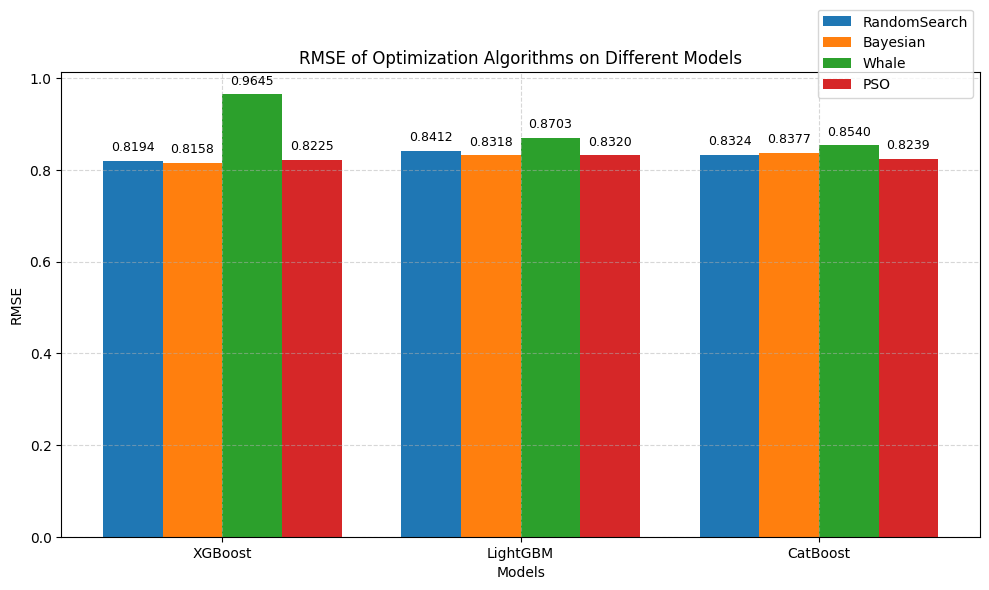

In [81]:
models = list(results.keys())
optimizers = list(next(iter(results.values())).keys())

# Matrix of RMSE values
rmse_values = [[results[model][opt] for opt in optimizers] for model in models]

x = np.arange(len(models))  # label locations
width = 0.2  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with RMSE labels
for i, opt in enumerate(optimizers):
    bar_positions = x + i * width
    rmse_for_opt = [results[model][opt] for model in models]
    bars = ax.bar(bar_positions, rmse_for_opt, width, label=opt)

    # Add value labels on top with 4 decimal places
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Formatting
ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('RMSE of Optimization Algorithms on Different Models')
ax.set_xticks(x + width * (len(optimizers) - 1) / 2)
ax.set_xticklabels(models)
ax.grid(True, linestyle='--', alpha=0.5)

# Legend at top-right, outside plot area
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15))

plt.tight_layout()
plt.show()


**Feature Correlation**

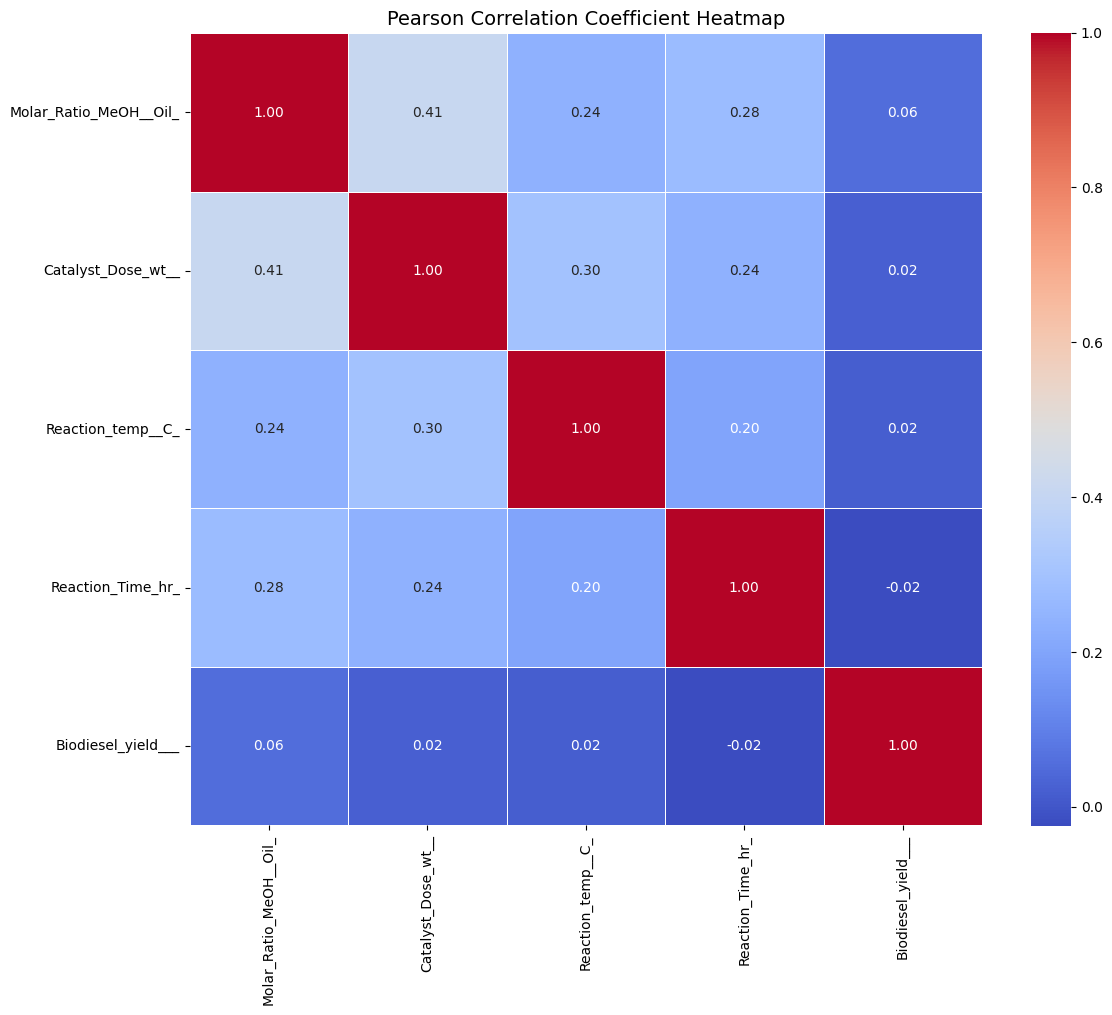

In [73]:
import seaborn as sns
# Compute the Pearson correlation matrix
correlation_matrix = df.corr(method='pearson')

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5)

# Set title
plt.title("Pearson Correlation Coefficient Heatmap", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

Feature importance

<Figure size 1000x600 with 0 Axes>

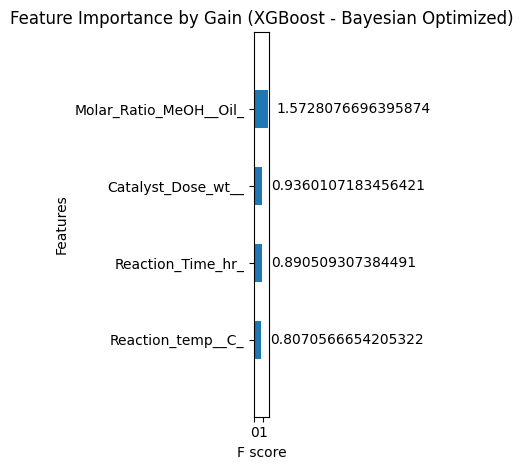

In [80]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from xgboost import XGBRegressor

# Re-train the Bayesian-optimized XGB model
xgb_model_for_plot = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_space = {
    'max_depth': (3, 10),
    'learning_rate': (1e-3, 0.3, 'log-uniform'),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

bayes_search = BayesSearchCV(
    estimator=xgb_model_for_plot,
    search_spaces=xgb_param_space,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

bayes_search.fit(X_train, y_train)
xgb_best_model = bayes_search.best_estimator_

# Plot feature importance based on 'gain'
plt.figure(figsize=(10, 6))
plot_importance(
    xgb_best_model,
    importance_type='gain',
    max_num_features=15,
    height=0.5,
    grid=False,
    show_values=True
)

plt.title('Feature Importance by Gain (XGBoost - Bayesian Optimized)')
plt.tight_layout()
plt.show()
